In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
#from glmnet import glmnet; from glmnetPlot import glmnetPlot
#from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
#from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
#from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

#from aml_utils import test_case_checker, perform_computation

warnings.filterwarnings('ignore')
perform_computation = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df = pd.read_csv('default_plus_chromatic_features_1059_tracks.txt', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,7.161286,7.835325,2.911583,0.984049,-1.499546,-2.094097,0.576000,-1.205671,1.849122,-0.425598,...,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-15.75,-47.95
1,0.225763,-0.094169,-0.603646,0.497745,0.874036,0.290280,-0.077659,-0.887385,0.432062,-0.093963,...,0.936616,0.936616,0.936616,0.936616,0.936616,0.936616,0.936616,0.936616,14.91,-23.51
2,-0.692525,-0.517801,-0.788035,1.214351,-0.907214,0.880213,0.406899,-0.694895,-0.901869,-1.701574,...,0.603755,0.603755,0.603755,0.603755,0.603755,0.603755,0.603755,0.603755,12.65,-8.00
3,-0.735562,-0.684055,2.058215,0.716328,-0.011393,0.805396,1.497982,0.114752,0.692847,0.052377,...,0.187169,0.187169,0.187169,0.187169,0.187169,0.187169,0.187169,0.187169,9.03,38.74
4,0.570272,0.273157,-0.279214,0.083456,1.049331,-0.869295,-0.265858,-0.401676,-0.872639,1.147483,...,1.620715,1.620715,1.620715,1.620715,1.620715,1.620715,1.620715,1.620715,34.03,-6.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,0.399577,0.310805,-0.039326,-0.111546,0.304586,-0.943453,0.114960,-0.335898,0.826753,-0.393786,...,-0.415247,-0.415247,-0.415247,-0.415247,-0.415247,-0.415247,-0.415247,-0.415247,-6.17,35.74
1055,1.640386,1.306224,0.192745,-1.816855,-1.311906,-2.128963,-1.875967,0.094232,-1.429742,0.873777,...,-0.817538,-0.817538,-0.817538,-0.817538,-0.817538,-0.817538,-0.817538,-0.817538,11.55,104.91
1056,-0.772360,-0.670596,-0.840420,-0.832105,0.277346,1.152162,0.241470,0.229092,0.019036,-0.068804,...,-0.515309,-0.515309,-0.515309,-0.515309,-0.515309,-0.515309,-0.515309,-0.515309,41.33,19.80
1057,-0.996965,-1.099395,3.515274,-0.508185,-1.102654,0.192081,0.069821,0.264674,-0.411533,0.501164,...,0.074855,0.074855,0.074855,0.074855,0.074855,0.074855,0.074855,0.074855,54.68,25.31


In [8]:
X_full = df.iloc[:,:-2].values
lat_full = df.iloc[:,-2].values
lon_full = df.iloc[:,-1].values
X_full.shape, lat_full.shape, lon_full.shape

((1059, 116), (1059,), (1059,))

In [9]:
lat_full = 90 + lat_full
lon_full = 180 + lon_full

In [10]:
outlier_detector = 'LOF'

if outlier_detector == 'LOF':
    outlier_clf = LocalOutlierFactor(novelty=False)
elif outlier_detector == 'IF':
    outlier_clf = IsolationForest(warm_start=True, random_state=12345)
elif outlier_detector == 'EE':
    outlier_clf = EllipticEnvelope(random_state=12345)
else:
    outlier_clf = None

is_not_outlier = outlier_clf.fit_predict(X_full) if outlier_clf is not None else np.ones_like(lat_full)>0
X_useful = X_full[is_not_outlier==1,:]
lat_useful = lat_full[is_not_outlier==1]
lon_useful = lon_full[is_not_outlier==1]

In [11]:
train_val_indices, test_indices = train_test_split(np.arange(X_useful.shape[0]), test_size=0.2, random_state=12345)

X_train_val = X_useful[train_val_indices, :]
lat_train_val = lat_useful[train_val_indices]
lon_train_val = lon_useful[train_val_indices]

X_test = X_useful[test_indices, :]
lat_test = lat_useful[test_indices]
lon_test = lon_useful[test_indices]

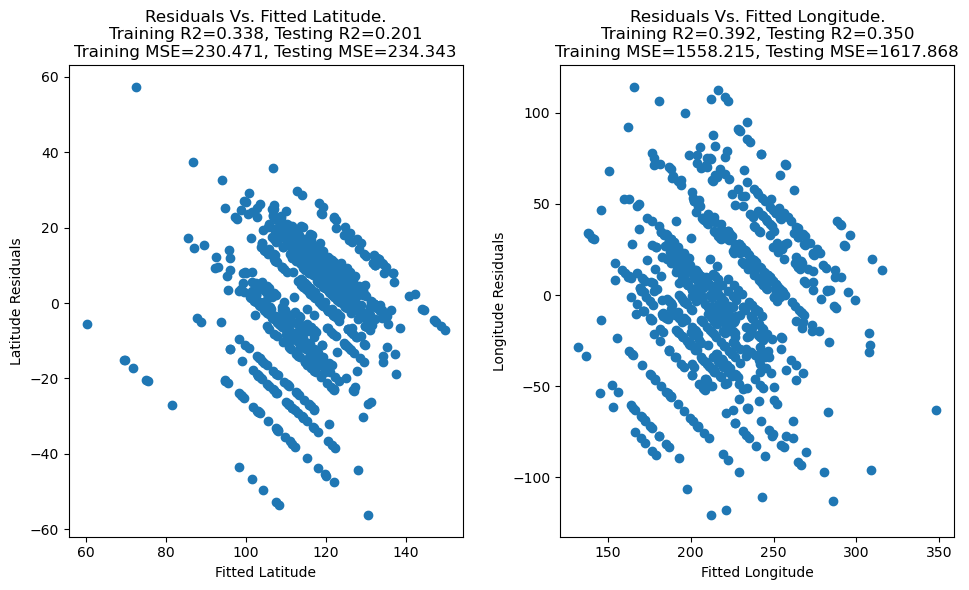

In [13]:
from sklearn.linear_model import LinearRegression

if perform_computation:
    X, Y = X_train_val, lat_train_val
    reg_lat = LinearRegression().fit(X, Y)
    train_r2_lat = reg_lat.score(X,Y)
    fitted_lat = reg_lat.predict(X)
    residuals_lat = Y-fitted_lat
    train_mse_lat = (residuals_lat**2).mean()
    test_mse_lat = np.mean((reg_lat.predict(X_test)-lat_test)**2)
    test_r2_lat = reg_lat.score(X_test,lat_test)

    X, Y = X_train_val, lon_train_val
    reg_lon = LinearRegression().fit(X, Y)
    train_r2_lon = reg_lon.score(X,Y)
    fitted_lon = reg_lon.predict(X)
    residuals_lon = Y-fitted_lon
    train_mse_lon = (residuals_lon**2).mean()
    test_mse_lon = np.mean((reg_lon.predict(X_test)-lon_test)**2)
    test_r2_lon = reg_lon.score(X_test,lon_test)

    fig, axes = plt.subplots(1,2, figsize=(10,6.), dpi=100)

    ax = axes[0]
    ax.scatter(fitted_lat, residuals_lat)
    ax.set_xlabel('Fitted Latitude')
    ax.set_ylabel('Latitude Residuals')
    _ = ax.set_title(f'Residuals Vs. Fitted Latitude.\n' +
                     f'Training R2=%.3f, Testing R2=%.3f\n' % (train_r2_lat, test_r2_lat) +
                     f'Training MSE=%.3f, Testing MSE=%.3f' % (train_mse_lat, test_mse_lat))

    ax = axes[1]
    ax.scatter(fitted_lon, residuals_lon)
    ax.set_xlabel('Fitted Longitude')
    ax.set_ylabel('Longitude Residuals')
    _ = ax.set_title(f'Residuals Vs. Fitted Longitude.\n' +
                     f'Training R2=%.3f, Testing R2=%.3f\n' % (train_r2_lon, test_r2_lon) +
                     f'Training MSE=%.3f, Testing MSE=%.3f' % (train_mse_lon, test_mse_lon))
    fig.set_tight_layout([0, 0, 1, 1])
